Richter's Predictor: Modeling Earthquake Damage from drivendata.com
In this project I used optuna in combination with multiple XGBoost boosters to achieve a score on drivendata.com of 0.7200. Current rank:983 out of 5620 competitors

In [1]:
%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
# for preprocessing the data
from sklearn.preprocessing import StandardScaler

# the model
from sklearn.ensemble import RandomForestClassifier

# for combining the preprocess with model training
from sklearn.pipeline import make_pipeline

# for optimizing the hyperparameters of the pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

In [2]:
train_values = pd.read_csv('train_values.csv', index_col='building_id')
train_labels = pd.read_csv('train_labels.csv', index_col='building_id')

In [3]:
pd.options.display.max_columns = train_values.shape[1]
train_values.describe()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
count,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000
mean,13.900353,701.074685,6257.876148,2.129723,26.535029,8.018051,5.434365,0.088645,0.761935,0.034332,0.018235,0.068154,0.075268,0.254988,0.085011,0.042590,0.015859,0.014985,0.983949,0.111880,0.064378,0.033626,0.008101,0.000940,0.000361,0.001071,0.000188,0.000146,0.000088,0.005119
std,8.033617,412.710734,3646.369645,0.727665,73.565937,4.392231,1.918418,0.284231,0.425900,0.182081,0.133800,0.252010,0.263824,0.435855,0.278899,0.201931,0.124932,0.121491,0.418389,0.315219,0.245426,0.180265,0.089638,0.030647,0.018989,0.032703,0.013711,0.012075,0.009394,0.071364
min,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,350.000000,3073.000000,2.000000,10.000000,5.000000,4.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,12.000000,702.000000,6270.000000,2.000000,15.000000,7.000000,5.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,21.000000,1050.000000,9412.000000,2.000000,30.000000,9.000000,6.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,30.000000,1427.000000,12567.000000,9.000000,995.000000,100.000000,32.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


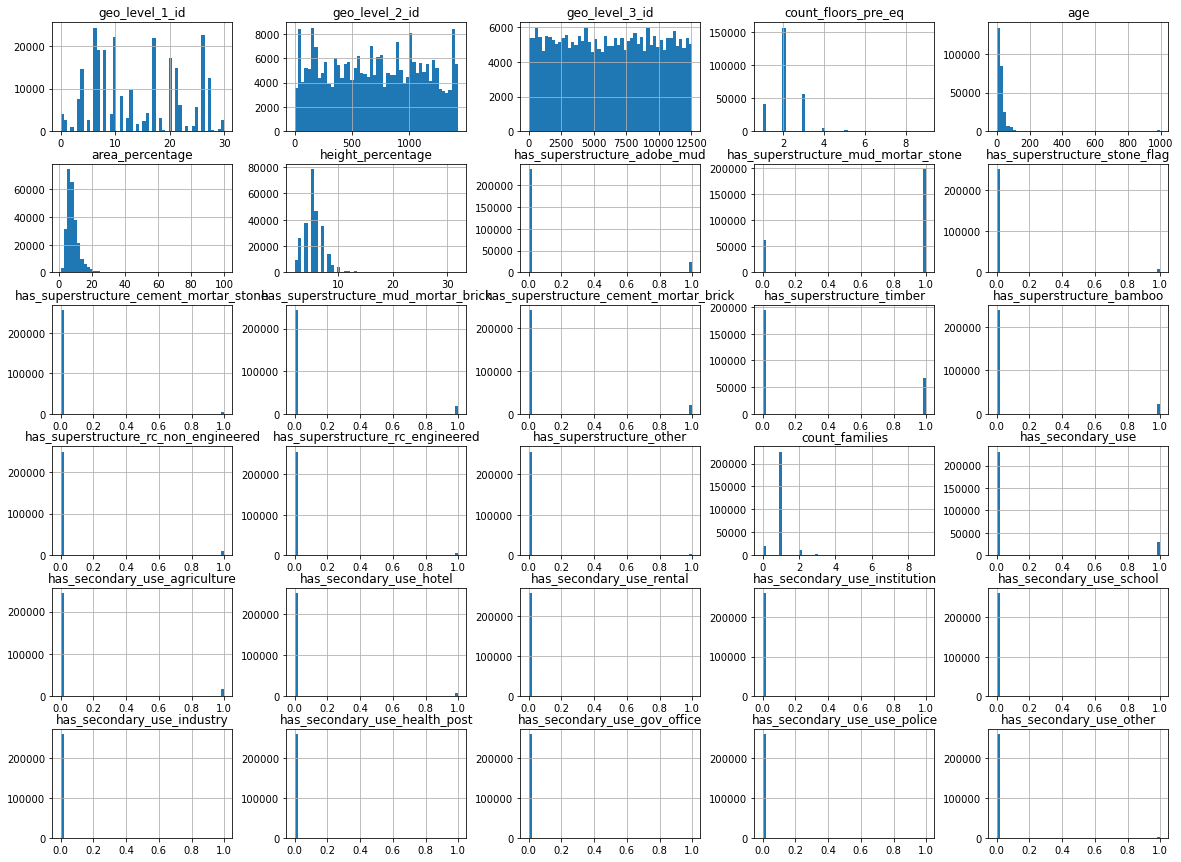

In [4]:
train_values.hist(bins=50, figsize=(20,15)) 
plt.show()

In [5]:
df=pd.merge(train_values, train_labels, on='building_id')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 802906 to 747594
Data columns (total 39 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   geo_level_1_id                          260601 non-null  int64 
 1   geo_level_2_id                          260601 non-null  int64 
 2   geo_level_3_id                          260601 non-null  int64 
 3   count_floors_pre_eq                     260601 non-null  int64 
 4   age                                     260601 non-null  int64 
 5   area_percentage                         260601 non-null  int64 
 6   height_percentage                       260601 non-null  int64 
 7   land_surface_condition                  260601 non-null  object
 8   foundation_type                         260601 non-null  object
 9   roof_type                               260601 non-null  object
 10  ground_floor_type                       260601 non-

In [7]:
for col in ['legal_ownership_status', 'plan_configuration', 'position', 'other_floor_type','ground_floor_type','roof_type','foundation_type','land_surface_condition']:
    df[col] = df[col].astype('category')

In [8]:
#features I could argue are redundant/irrelevant
df = df.drop(['has_secondary_use_use_police',
              'has_secondary_use_health_post','legal_ownership_status', 'has_secondary_use_gov_office',
              'has_secondary_use_industry','has_secondary_use_school',
             'has_secondary_use_other','has_secondary_use_institution', 'has_secondary_use_agriculture',
             'geo_level_3_id', 'has_secondary_use_hotel','has_secondary_use', 'count_families', 'has_secondary_use_rental' ], axis=1)

In [9]:
df.describe()

,geo_level_1_id,geo_level_2_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,damage_grade
count,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000
mean,13.900353,701.074685,2.129723,26.535029,8.018051,5.434365,0.088645,0.761935,0.034332,0.018235,0.068154,0.075268,0.254988,0.085011,0.042590,0.015859,0.014985,2.238272
std,8.033617,412.710734,0.727665,73.565937,4.392231,1.918418,0.284231,0.425900,0.182081,0.133800,0.252010,0.263824,0.435855,0.278899,0.201931,0.124932,0.121491,0.611814
min,0.000000,0.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,7.000000,350.000000,2.000000,10.000000,5.000000,4.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,12.000000,702.000000,2.000000,15.000000,7.000000,5.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,21.000000,1050.000000,2.000000,30.000000,9.000000,6.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,30.000000,1427.000000,9.000000,995.000000,100.000000,32.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000


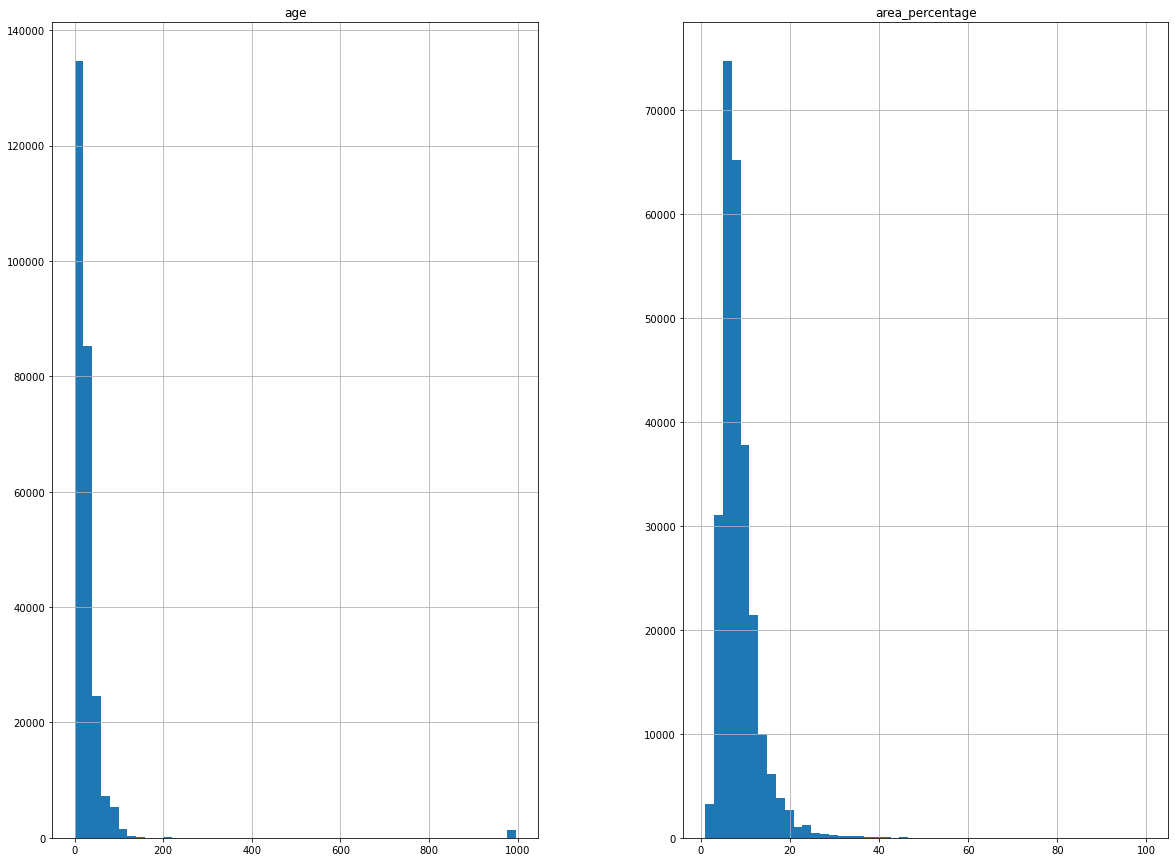

In [10]:
df[['age','area_percentage']].hist(bins=50, figsize=(20,15)) 
plt.show()

In [11]:
df[['age','area_percentage']].describe()

,age,area_percentage
count,260601.000000,260601.000000
mean,26.535029,8.018051
std,73.565937,4.392231
min,0.000000,1.000000
25%,10.000000,5.000000
50%,15.000000,7.000000
75%,30.000000,9.000000
max,995.000000,100.000000


In [12]:
df[['age','area_percentage']].sort_values(by=['age','area_percentage'], ascending=False)

,age,area_percentage
building_id,,
155009,995,34
769473,995,34
333924,995,34
810018,995,34
364452,995,31
...,...,...
753892,0,1
696388,0,1
529907,0,1


In [13]:
df.drop(df[df['age'] >= 240].index, inplace = True)

In [14]:
df.shape

(259211, 25)

In [15]:
df[['age','area_percentage']].sort_values(by=['age','area_percentage'], ascending=False)

,age,area_percentage
building_id,,
538437,200,38
39029,200,29
999127,200,25
612379,200,25
44346,200,25
...,...,...
753892,0,1
696388,0,1
529907,0,1


In [16]:
df.drop(df[df['age'] >= 200].index, inplace = True)

<AxesSubplot:>

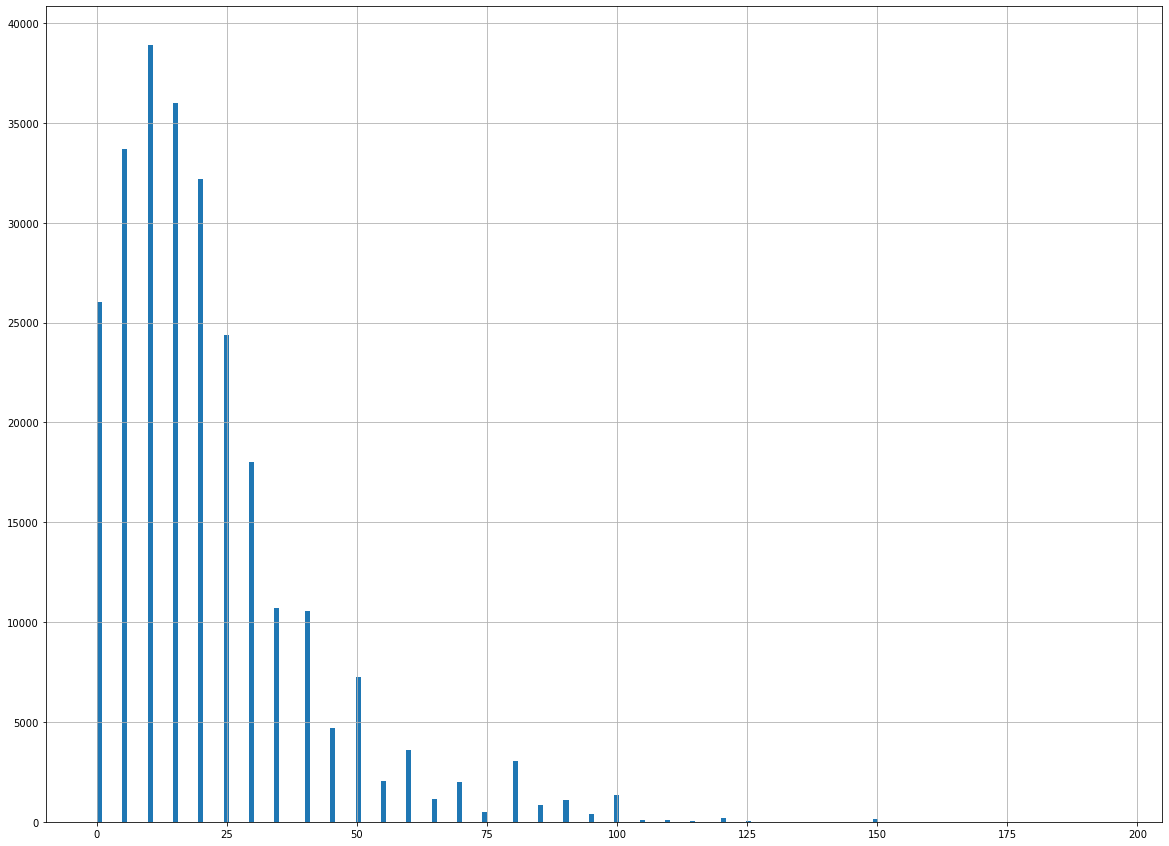

In [17]:
df['age'].hist(bins=200, figsize=(20,15))

<AxesSubplot:>

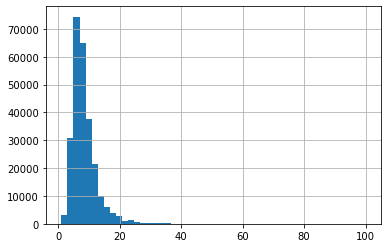

In [18]:
df['area_percentage'].hist(bins=50)


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 259105 entries, 802906 to 747594
Data columns (total 25 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   geo_level_1_id                          259105 non-null  int64   
 1   geo_level_2_id                          259105 non-null  int64   
 2   count_floors_pre_eq                     259105 non-null  int64   
 3   age                                     259105 non-null  int64   
 4   area_percentage                         259105 non-null  int64   
 5   height_percentage                       259105 non-null  int64   
 6   land_surface_condition                  259105 non-null  category
 7   foundation_type                         259105 non-null  category
 8   roof_type                               259105 non-null  category
 9   ground_floor_type                       259105 non-null  category
 10  other_floor_type           

In [20]:
import pandas as pd
from numpy import asarray
from sklearn.preprocessing import StandardScaler

In [21]:
col_names = ['geo_level_1_id', 'geo_level_2_id', 'count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage']
features = df[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)


In [22]:
corr_matrix = df.corr()
corr_matrix["damage_grade"].sort_values(ascending=False)

damage_grade                              1.000000
has_superstructure_mud_mortar_stone       0.291777
age                                       0.150381
count_floors_pre_eq                       0.123036
has_superstructure_stone_flag             0.066615
has_superstructure_adobe_mud              0.055910
height_percentage                         0.048482
geo_level_2_id                            0.042819
has_superstructure_mud_mortar_brick       0.014741
has_superstructure_other                 -0.029902
has_superstructure_cement_mortar_stone   -0.060600
has_superstructure_bamboo                -0.062358
has_superstructure_timber                -0.069001
geo_level_1_id                           -0.072183
area_percentage                          -0.124952
has_superstructure_rc_non_engineered     -0.158444
has_superstructure_rc_engineered         -0.179327
has_superstructure_cement_mortar_brick   -0.254598
Name: damage_grade, dtype: float64

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 259105 entries, 802906 to 747594
Data columns (total 25 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   geo_level_1_id                          259105 non-null  int64   
 1   geo_level_2_id                          259105 non-null  int64   
 2   count_floors_pre_eq                     259105 non-null  int64   
 3   age                                     259105 non-null  int64   
 4   area_percentage                         259105 non-null  int64   
 5   height_percentage                       259105 non-null  int64   
 6   land_surface_condition                  259105 non-null  category
 7   foundation_type                         259105 non-null  category
 8   roof_type                               259105 non-null  category
 9   ground_floor_type                       259105 non-null  category
 10  other_floor_type           

In [24]:
df=pd.get_dummies(data=df, columns=['land_surface_condition', 'foundation_type',
                                 'roof_type', 'ground_floor_type',
                                 'other_floor_type', 'position',
                                 'plan_configuration'])

In [25]:
df1 = df.pop('damage_grade') # move damage_grade to last
df['damage_grade']=df1

df.columns

Index(['geo_level_1_id', 'geo_level_2_id', 'count_floors_pre_eq', 'age',
       'area_percentage', 'height_percentage', 'has_superstructure_adobe_mud',
       'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other',
       'land_surface_condition_n', 'land_surface_condition_o',
       'land_surface_condition_t', 'foundation_type_h', 'foundation_type_i',
       'foundation_type_r', 'foundation_type_u', 'foundation_type_w',
       'roof_type_n', 'roof_type_q', 'roof_type_x', 'ground_floor_type_f',
       'ground_floor_type_m', 'ground_floor_type_v', 'ground_floor_type_x',
       'ground_floor_type_z', 'other_floor_type_j', 'other_floor_type_q',
       'other_

In [27]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score #f1_score(y_test, y_pred, average='micro')

In [28]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.25)

In [30]:
%%time
xgb = XGBClassifier(booster='gbtree', objective='mlogloss', enable_categorical=True,
                    learning_rate=0.1, n_estimators=100, random_state=2, n_jobs=-1)
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)
score = f1_score(y_test, y_pred, average='micro')
print('Score: ' + str(score))

Score: 0.6725535298022446
CPU times: user 57.2 s, sys: 246 ms, total: 57.4 s
Wall time: 57.5 s


In [31]:
model = XGBClassifier(booster='gbtree', random_state=2, silent=True)


In [32]:
# Import cross_val_score
from sklearn.model_selection import cross_val_score

# Import numpy
import numpy as np

# Obtain scores of cross-validation
scores = cross_val_score(model, X, y, cv=5)

# Display accuracy
print('Accuracy:', np.round(scores, 2))

# Display mean accuracy
print('Accuracy mean: %0.2f' % (scores.mean()))


    # Import StratifiedKFold
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)

# Obtain scores of cross-validation
scores = cross_val_score(model, X, y, cv=kfold)

# Display accuracy
print('Accuracy:', np.round(scores, 2))

# Display mean accuracy
print('Accuracy mean: %0.2f' % (scores.mean()))

Accuracy: [0.68 0.67 0.67 0.67 0.68]
Accuracy mean: 0.67
Accuracy: [0.67 0.67 0.67 0.67 0.68]
Accuracy mean: 0.67


In [33]:
%%time

# Import GridSearchCV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)

def grid_search(params, random=False): 
    
    xgb = XGBClassifier(booster='gbtree', objective='multi:softprob', random_state=2, silent=True)
    
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
    
    if random:
        grid = RandomizedSearchCV(xgb, params, cv=kfold, n_iter=20, n_jobs=-1, random_state=2)
    else:
        # Instantiate GridSearchCV as grid_reg
        grid = GridSearchCV(xgb, params, cv=kfold, n_jobs=-1)
    
    # Fit grid_reg on X_train and y_train
    grid.fit(X, y)

    # Extract best params
    best_params = grid.best_params_

    # Print best params
    print("Best params:", best_params)
    
    # Compute best score
    best_score = grid.best_score_

    # Print best score
    print("Best score: {:.5f}".format(best_score))
    
    #Our function can now be used to tune the hyperparameters


CPU times: user 21 µs, sys: 7 µs, total: 28 µs
Wall time: 30 µs


In [35]:
%%time

grid_search(params={'gamma':[0.5], 
                    'colsample_bylevel':[1], 
                    'colsample_bytree':[0.9],
                    'max_delta_step':[3], 
                    'max_depth':[8], 
                    'n_estimators':[150]})

Best params: {'colsample_bylevel': 1, 'colsample_bytree': 0.9, 'gamma': 0.5, 'max_delta_step': 3, 'max_depth': 8, 'n_estimators': 150}
Best score: 0.72205
CPU times: user 4min 40s, sys: 1.3 s, total: 4min 42s
Wall time: 10min 4s


In [38]:
y_test1 = pd.read_csv('test_values.csv', index_col='building_id')
#clean and transform data as before, standardscaler?No
y_test1 = y_test1.drop(['has_secondary_use_use_police',
              'has_secondary_use_health_post','legal_ownership_status', 'has_secondary_use_gov_office',
              'has_secondary_use_industry','has_secondary_use_school',
             'has_secondary_use_other','has_secondary_use_institution', 'has_secondary_use_agriculture',
             'geo_level_3_id', 'has_secondary_use_hotel','has_secondary_use', 'count_families', 'has_secondary_use_rental' ], axis=1)
y_test1.head()



,geo_level_1_id,geo_level_2_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other
building_id,,,,,,,,,,,,,,,,,,,,,,,,
300051,17,596,3,20,7,6,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0
99355,6,141,2,25,13,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0
890251,22,19,2,5,4,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0
745817,26,39,1,0,19,3,t,r,x,v,j,t,d,0,0,0,0,0,1,0,0,0,0,0
421793,17,289,3,15,8,7,t,r,q,f,q,t,d,0,1,0,0,0,0,0,0,0,0,0


In [39]:
col_names = ['geo_level_1_id', 'geo_level_2_id', 'count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage']
features = y_test1[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

In [40]:
y_test1=pd.get_dummies(data=y_test1, columns=['land_surface_condition', 'foundation_type',
                                 'roof_type', 'ground_floor_type',
                                 'other_floor_type', 'position',
                                 'plan_configuration'])

In [49]:
%%time
f_model = XGBClassifier(booster='gbtree', random_state=2,gamma=0.5, 
                    colsample_bylevel=1, 
                    colsample_bytree=0.9,
                    max_delta_step=3, 
                    max_depth=8, 
                    n_estimators=150)


y_pred = model.predict(y_test1)


CPU times: user 2.38 s, sys: 46.9 ms, total: 2.43 s
Wall time: 2.43 s


In [80]:
y_test1['damage_grade']=y_pred


/var/folders/n8/m10mq31s5kg1_vj_w5j9h8d80000gn/T/ipykernel_35283/1111223294.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test1['damage_grade']=y_pred


In [81]:
y_test1 = y_test1.filter(like='damage_grade')

In [82]:
y_test1.head()

,damage_grade
building_id,
300051,3
99355,2
890251,2
745817,1
421793,3


In [83]:
y_test1.to_csv('prediction.csv')
